In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pylab as pl
get_ipython().magic('matplotlib inline')
from datetime import datetime as dt
import pandas as pd
import sklearn
from sklearn import linear_model
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
sns.set_style("whitegrid")

/Users/galwachtel/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/galwachtel/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#A function built to organize data; this is later replaced with a pandas dataframe. 
def dengue_incidence_searches(f):    
    with open(f) as file:
        dengue_searches=[]   
        dengue_cdc=[]
        dates=[]
        for l in file:
            line=l.strip()
            if line: 
                l=[x for x in l.split()]
                dates.append(str(l[0]))
                dengue_searches.append(float(l[2]))
                dengue_cdc.append(float(l[1]))
    return(dengue_searches, dengue_cdc, dates)

In [3]:
dengue_data=dengue_incidence_searches('Dengue_trends_AM_111_training.txt')
dates=[dt.strptime(l, '%m/%d/%y') for l in dengue_data[2]]

## a. Plotting dengue incidence

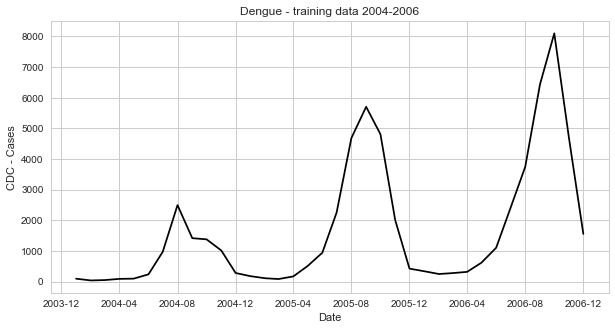

In [4]:
fig=plt.figure(figsize=(10, 5))
ax=fig.add_subplot(111)
x=dates
y=dengue_data[1]
ax.plot(x, y, 'k')
pl.xlabel('Date')
pl.ylabel('CDC - Cases')
pl.title('Dengue - training data 2004-2006')
pl.show()

## b. Fitting a linear regression using ols

In [5]:
#A function which runs an OLS regression and returns its parameters:
def fitOLS(xval, yval):
    ols=sm.OLS(yval, sm.tools.add_constant(xval)).fit()
    b,a=ols.params
    return (b, a)

In [6]:
Slope, Error = fitOLS(dengue_data[0], dengue_data[1])
print('Slope:', Slope, 'Error:', Error)

Slope: 2155.25181371 Error: 2926.37898735


## c.

In [64]:
#Predicting dengue cases form the ols parameters:
b=fitOLS(dengue_data[0], dengue_data[1])[0]
a=fitOLS(dengue_data[0], dengue_data[1])[1]
predicted_dengue_0406=[x*b+a for x in dengue_data[0]]
dates=[dt.strptime(l, '%m/%d/%y') for l in dengue_data[2]]

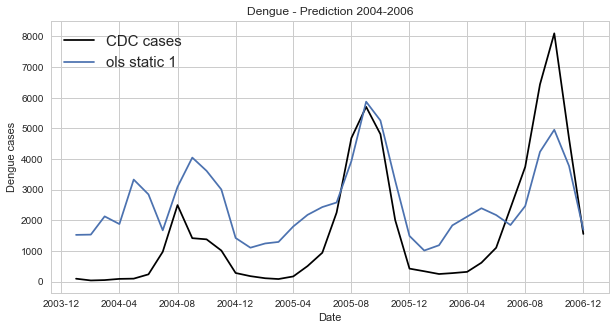

In [8]:
fig=plt.figure(figsize=(10, 5))
x=dates
y=dengue_data[1]
plt.plot(x, y, 'k', label='CDC cases')
plt.plot(x, predicted_dengue_0406, label='ols static 1')
pl.xlabel('Date')
pl.ylabel('Dengue cases')
pl.title('Dengue - Prediction 2004-2006')
pl.legend(loc='upper left', prop={'size':15})
pl.show()

## d. Prediction of dengue incidence using ols - with training set

In [9]:
dengue_data_2007_2011=dengue_incidence_searches('Dengue_trends_AM_111_prediction.txt')

In [10]:
predicted_dengue_2007_2011=[x*b+a for x in dengue_data_2007_2011[0]]
dates=[dt.strptime(l, '%m/%d/%y') for l in dengue_data_2007_2011[2]]

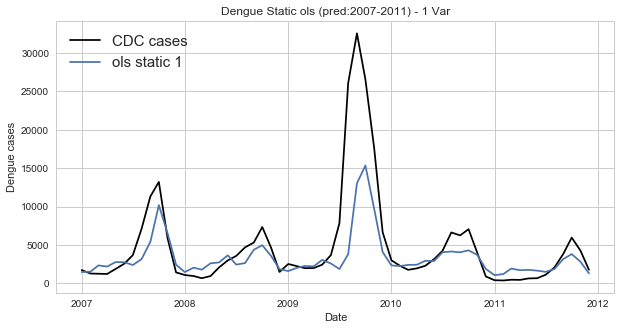

In [11]:
fig=plt.figure(figsize=(10, 5))
ax=fig.add_subplot(111)
x=dates
y=dengue_data_2007_2011[1] 
ax.plot(x, y, 'k', label='CDC cases')
ax.plot(x, predicted_dengue_2007_2011, label='ols static 1')
pl.xlabel('Date')
pl.ylabel('Dengue cases')
pl.title('Dengue Static ols (pred:2007-2011) - 1 Var')
pl.legend(loc='upper left', prop={'size':15})
pl.show()

The major flaw of using OLS fpr prediction of dengue incidence is that we are trying to model data which is clearly nonlinear by using a linear model. By examining the training data set we are able to see that dengue incidence is cyclical and clealy not linear. Thus using maximum likelihood would possibly yield a tigghter prediction as it is more suited for nonlinear data. In addition, calculating the parameters in smaller increments, i.e. dynamically, should yield a tighter fit.

## Continuation - Dynamic training

In [67]:
#The following function runs an ols regression every time a new data point is entered, yielding a list of dynamic ols parameters:
def fitOLS_dynamic(xval, yval):
    blist=[]
    alist=[]
    for i in range(len(xval)):
        if i>=1:
            y=yval[:i+1]
            x=xval[:i+1]
            ols=sm.OLS(y, sm.tools.add_constant(x)).fit()
            b,a=ols.params
            blist.append(b)
            alist.append(a)
    return (blist, alist)

In [13]:
dengue_data_total=dengue_incidence_searches('Dengue_trends_AM_111_total.txt')
dates=[dt.strptime(l, '%m/%d/%y') for l in dengue_data_total[2]]

In [68]:
#Predicting dengue cases based on updated ols parameters:
slope=fitOLS_dynamic(dengue_data_total[0], dengue_data_total[1])[0]
error=fitOLS_dynamic(dengue_data_total[0], dengue_data_total[1])[1]
predicted_dengue=[]
for i in range(len(dengue_data_total[0])):
    if i<=1:
        predicted_dengue.append(dengue_data_total[1][i])
    if i>1:
        pred=dengue_data_total[0][i]*slope[i-1]+error[i-1] 
        predicted_dengue.append(pred)

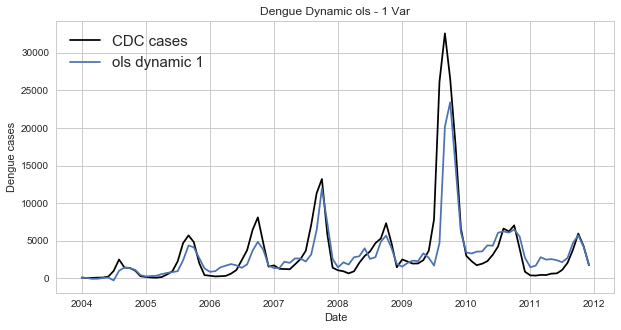

In [15]:
fig=plt.figure(figsize=(10, 5))
ax=fig.add_subplot(111)
x=dates
y=dengue_data_total[1]
ax.plot(x, y, 'k', label='CDC cases')
ax.plot(x, predicted_dengue, label='ols dynamic 1')
pl.xlabel('Date')
pl.ylabel('Dengue cases')
pl.title('Dengue Dynamic ols - 1 Var')
pl.legend(loc='upper left', prop={'size':15})
pl.show()

## Additional variables 

### Static

In [5]:
dengue_multi=pd.read_csv('GT_Mexico.csv')

In [6]:
dengue_multi.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
dengue_multi.rename(columns={'sintomas.del.dengue':'sintomas.dl.dengue'}, inplace=True)

In [7]:
dengue_multi['Date_dt']=[dt.strptime(l, '%m/%d/%y') for l in dengue_multi['Date']]

In [8]:
dengue_multi = dengue_multi[['Date', 'Date_dt', 'dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito']]

In [9]:
dengue_copy = dengue_multi.copy()
dengue_copy['year'] = dengue_copy['Date_dt'].dt.year
dengue_copy['month'] = dengue_copy['Date_dt'].dt.month

In [10]:
#Averaging searches over every given month so as to format according to available CDC case count data:
GB=dengue_copy.groupby([(dengue_copy['year']),(dengue_copy['month'])]).mean()
GB=GB.reset_index(drop=True)

In [11]:
denguecount=pd.read_csv('CaseCount(Mexico).csv')
denguecount.head()

,Unnamed: 0,date,N_cases
0,1,Jan 1990,533
1,2,Feb 1990,448
2,3,Mar 1990,300
3,4,Apr 1990,201
4,5,May 1990,182


In [12]:
del denguecount['Unnamed: 0']

In [13]:
#Converting string into datetime:
denguecount['date']=[dt.strptime(l, '%b %Y') for l in denguecount['date']]

In [14]:
#Matching CDC count with google search data based on date and adding the case count to the dataframe:
GB['N_cases'] = np.zeros(len(GB['dengue']))
for row in range(len(GB['dengue'])):
    for line in range(len(denguecount['date'])):
        if denguecount['date'][line].year == GB['year'][row] and denguecount['date'][line].month == GB['month'][row]:
            GB.set_value(row, 'N_cases', denguecount['N_cases'][line])

In [15]:
#Determing the index of the end of the training set:
GB[GB['year'] == 2016]

,dengue,dengue.dengue.dengue,el.dengue,dengue.sintomas,sintomas.dl.dengue,dengue.hemorragico,sintomas.de.dengue,que.es.dengue,dengue.clasico,dengue.mosquito,year,month,N_cases
144,11.00,11.6,10.00,14.00,17.40,5.00,13.60,9.60,5.0,7.40,2016.0,1.0,0.0
145,17.50,18.0,15.75,23.00,27.50,6.25,25.00,16.50,7.0,16.25,2016.0,2.0,0.0
146,17.00,17.0,18.75,19.00,22.00,5.25,23.25,21.50,6.5,17.00,2016.0,3.0,0.0
147,12.75,12.5,11.50,14.75,16.75,5.25,15.00,11.75,5.5,11.00,2016.0,4.0,0.0


In [16]:
#Fitiing a linear regression (ols):
reg=linear_model.LinearRegression()
reg.fit(GB.ix[0:36, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito']], GB.ix[0:36, 'N_cases'])

/Users/galwachtel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
#Constructing a prediction using the above linear regression:
ps_multi=reg.predict(GB.ix[36: , ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito']])

In [18]:
#Recreating a dates column post grouping:
GB['dates_rec']=pd.to_datetime({'year':GB.year, 'month':GB.month, 'day': [1]*len(GB['dengue'])})

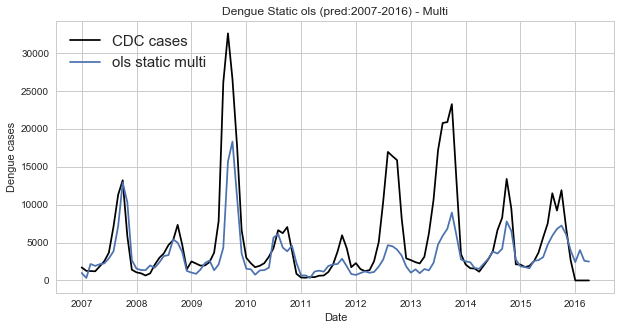

In [19]:
fig=plt.figure(figsize=(10, 5))
plt.plot(GB['dates_rec'][36:], GB['N_cases'][36:], 'k', label='CDC cases')
plt.plot(GB['dates_rec'][36:], ps_multi, label='ols static multi')
plt.xlabel('Date')
plt.ylabel('Dengue cases')
plt.title('Dengue Static ols (pred:2007-2016) - Multi')
pl.legend(loc='upper left', prop={'size':15})
plt.show()

### Dynamic

In [20]:
#Creating a dynamic prediction which updates the parameters with the addition of every month's data.
GB['Predicted']=np.zeros(len(GB['dengue']))
dynamicreg=linear_model.LinearRegression()
for i in range(len(GB['dengue'])):
    if i<=1:
        GB.set_value(i, 'Predicted', GB['N_cases'][i])       
    if i>1:        
        dynamicreg.fit(np.asarray(GB.ix[0:i-1, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito']]), np.asarray(list(GB.ix[0:i-1, 'N_cases'].as_matrix())))
        x=np.asarray(list(GB.ix[i, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito']].as_matrix()))
        prd=dynamicreg.predict(x.reshape([1, 10]))
        GB.set_value(i, 'Predicted', prd)

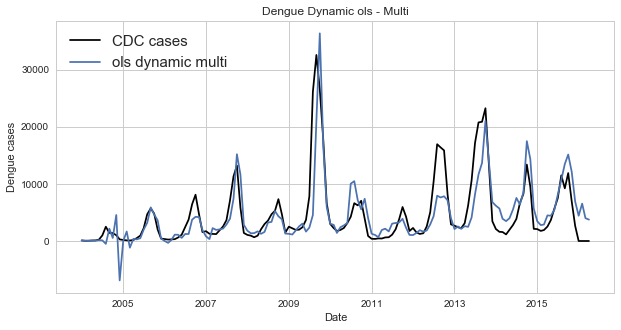

In [33]:
fig=plt.figure(figsize=(10, 5))
plt.plot(GB['dates_rec'], GB['N_cases'], 'k', label='CDC cases')
plt.plot(GB['dates_rec'], GB['Predicted'], label='ols dynamic multi')
plt.xlabel('Date')
plt.ylabel('Dengue cases')
plt.title('Dengue Dynamic ols - Multi')
pl.legend(loc='upper left', prop={'size':15})
plt.show()

## Seasonality 

In [36]:
#Adding a column with the number of dengue cases in that particular motnh two years prior:
GB['Case_2yr']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>24:
        GB.set_value(i, 'Case_2yr', GB['N_cases'][i-24])
    else:
        GB.set_value(i, 'Case_2yr', GB['N_cases'][i])

In [37]:
#Adding columns with the dengue cases per every month in the year prior to the month being evaluated:
GB['-1']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-1', GB['N_cases'][i-1])
    else:
        GB.set_value(i, '-1', GB['N_cases'][i])
GB['-2']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-2', GB['N_cases'][i-2])
    else:
        GB.set_value(i, '-2', GB['N_cases'][i])
GB['-3']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-3', GB['N_cases'][i-3])
    else:
        GB.set_value(i, '-3', GB['N_cases'][i])
GB['-4']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-4', GB['N_cases'][i-4])
    else:
        GB.set_value(i, '-4', GB['N_cases'][i])
GB['-5']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-5', GB['N_cases'][i-5])
    else:
        GB.set_value(i, '-5', GB['N_cases'][i])
GB['-6']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-6', GB['N_cases'][i-6])
    else:
        GB.set_value(i, '-6', GB['N_cases'][i])
GB['-7']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-7', GB['N_cases'][i-7])
    else:
        GB.set_value(i, '-7', GB['N_cases'][i])
GB['-8']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-8', GB['N_cases'][i-8])
    else:
        GB.set_value(i, '-8', GB['N_cases'][i])
GB['-9']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-9', GB['N_cases'][i-9])
    else:
        GB.set_value(i, '-9', GB['N_cases'][i])
GB['-10']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-10', GB['N_cases'][i-10])
    else:
        GB.set_value(i, '-10', GB['N_cases'][i])
GB['-11']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-11', GB['N_cases'][i-11])
    else:
        GB.set_value(i, '-11', GB['N_cases'][i])
GB['-12']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i>12:
        GB.set_value(i, '-12', GB['N_cases'][i-12])
    else:
        GB.set_value(i, '-12', GB['N_cases'][i])

### Static

In [39]:
#Static lasso (ARGO):
GB['Predicted_12U24_3yrlassostatic']=np.zeros(len(GB['dengue']))
folds = KFold(36, n_folds=3, shuffle=True)
dynamicreg=linear_model.LassoCV(cv=folds, n_alphas=200, max_iter=20000, tol=.0005, normalize=False, n_jobs=3)
for i in range(len(GB['dengue'])):
    if i<=36:
        GB.set_value(i, 'Predicted_12U24_3yrlassostatic', GB['N_cases'][i])       
    if i>36:        
    
        dynamicreg.fit(np.asarray(GB.ix[0:36, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito', 
                                        'Case_2yr', '-1', '-2', '-3',  '-11', '-12']]), np.asarray(list(GB.ix[0:36, 'N_cases'].as_matrix())))
        x=np.asarray(list(GB.ix[i, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 
                                         'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito', 'Case_2yr', '-1', '-2', '-3', '-11', '-12']].as_matrix()))
        prd=dynamicreg.predict(x.reshape([1, 16]))
        GB.set_value(i, 'Predicted_12U24_3yrlassostatic', prd)

In [40]:
#Static ols:
GB['static_seasonal_ols']=np.zeros(len(GB['dengue']))
dynamicreg=linear_model.LinearRegression()
for i in range(len(GB['dengue'])):
    if i<=24:
        GB.set_value(i, 'static_seasonal_ols', GB['N_cases'][i])       
    if i>24:        
    
        dynamicreg.fit(np.asarray(GB.ix[0:24, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 
                                                   'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito', 'Case_2yr',
                                                   '-1', '-2', '-3', '-4', '-5', '-6','-7', '-8', '-9', '-10', '-11', '-12']]), np.asarray(list(GB.ix[0:24, 'N_cases'].as_matrix())))
        x=np.asarray(list(GB.ix[i, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 
                                                   'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito', 'Case_2yr',
                                                   '-1', '-2', '-3', '-4', '-5', '-6','-7', '-8', '-9', '-10', '-11', '-12']].as_matrix()))
        prd=dynamicreg.predict(x.reshape([1, 23]))
        GB.set_value(i, 'static_seasonal_ols', prd)

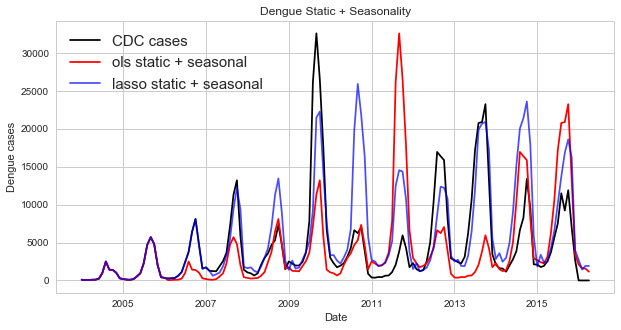

In [41]:
fig=plt.figure(figsize=(10, 5))
plt.plot(GB['dates_rec'], GB['N_cases'], 'k', label='CDC cases')
plt.plot(GB['dates_rec'], GB['static_seasonal_ols'], 'r', label='ols static + seasonal')
plt.plot(GB['dates_rec'], GB['Predicted_12U24_3yrlassostatic'], 'b', alpha=0.7, label='lasso static + seasonal')
plt.xlabel('Date')
plt.ylabel('Dengue cases')
plt.title('Dengue Static + Seasonality')
pl.legend(loc='upper left', prop={'size':15})
plt.show()

### Dynamic

In [43]:
#Dynamic using the data from the entire year prior and from the particular month 2 years prior ols (~ARGO):
GB['Predicted_12U24']=np.zeros(len(GB['dengue']))
dynamicreg=linear_model.LinearRegression()
for i in range(len(GB['dengue'])):
    if i<=1:
        GB.set_value(i, 'Predicted_12U24', GB['N_cases'][i])       
    if i>1:        
        dynamicreg.fit(np.asarray(GB.ix[0:i-1, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito', 'Case_2yr', '-1', '-2', '-3', '-4', '-5', '-6','-7', '-8', '-9', '-10', '-11', '-12']]), np.asarray(list(GB.ix[0:i-1, 'N_cases'].as_matrix())))
        x=np.asarray(list(GB.ix[i, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito', 'Case_2yr', '-1', '-2', '-3', '-4', '-5', '-6','-7', '-8', '-9', '-10', '-11', '-12']].as_matrix()))
        prd=dynamicreg.predict(x.reshape([1, 23]))
        GB.set_value(i, 'Predicted_12U24', prd)

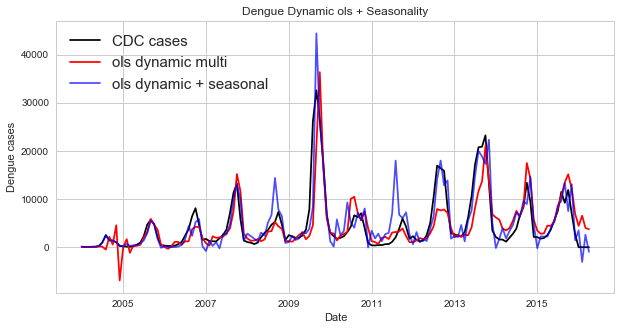

In [44]:
fig=plt.figure(figsize=(10, 5))
plt.plot(GB['dates_rec'], GB['N_cases'], 'k', label='CDC cases')
plt.plot(GB['dates_rec'], GB['Predicted'], 'r', label='ols dynamic multi')
plt.plot(GB['dates_rec'], GB['Predicted_12U24'], 'b', alpha=0.7, label='ols dynamic + seasonal')
plt.xlabel('Date')
plt.ylabel('Dengue cases')
plt.title('Dengue Dynamic ols + Seasonality')
pl.legend(loc='upper left', prop={'size':15})
plt.show()

The attept below to emulate the ARGO model using ols instead of lasso with a 2 yr training period was not succesful (as is evidnet in the graph that follows) since the number of available variables is equal to the number of trianing points which results in a non-unique solution. 

In [45]:
#2 year training time using the data from the entire year prior and from the particular month 2 years prior - ARGO model:       
GB['Predicted_12U24_2yr']=np.zeros(len(GB['dengue']))
dynamicreg=linear_model.LinearRegression()
for i in range(len(GB['dengue'])):
    if i<=24:
        GB.set_value(i, 'Predicted_12U24_2yr', GB['N_cases'][i])       
    if i>24:        
    
        dynamicreg.fit(np.asarray(GB.ix[i-24:i-1, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 
                                                   'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito', 'Case_2yr',
                                                   '-1', '-2', '-3', '-4', '-5', '-6','-7', '-8', '-9', '-10', '-11', '-12']]), np.asarray(list(GB.ix[i-24:i-1, 'N_cases'].as_matrix())))
        x=np.asarray(list(GB.ix[i, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 
                                                   'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito', 'Case_2yr',
                                                   '-1', '-2', '-3', '-4', '-5', '-6','-7', '-8', '-9', '-10', '-11', '-12']].as_matrix()))
        prd=dynamicreg.predict(x.reshape([1, 23]))
        GB.set_value(i, 'Predicted_12U24_2yr', prd)

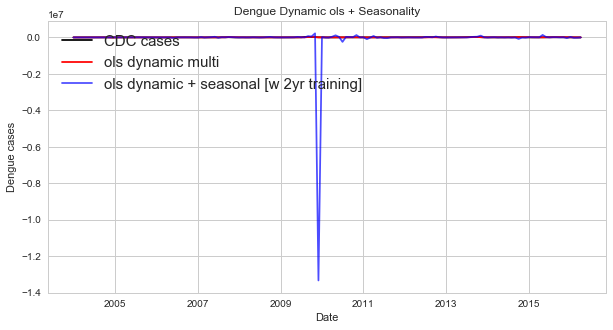

In [46]:
fig=plt.figure(figsize=(10, 5))
plt.plot(GB['dates_rec'], GB['N_cases'], 'k', label='CDC cases')
plt.plot(GB['dates_rec'], GB['Predicted'], 'r', label='ols dynamic multi')
plt.plot(GB['dates_rec'], GB['Predicted_12U24_2yr'], 'b', alpha=0.7, label='ols dynamic + seasonal [w 2yr training]')
plt.xlabel('Date')
plt.ylabel('Dengue cases')
plt.title('Dengue Dynamic ols + Seasonality')
pl.legend(loc='upper left', prop={'size':15})
plt.show()

In [48]:
#ARGO (dynamic, 3 yr training window, multi + seasonal):
folds = KFold(36, n_folds=3, shuffle=True)
GB['Predicted_12U24_3yrlasso']=np.zeros(len(GB['dengue']))
dynamicreg=linear_model.LassoCV(cv=folds, n_alphas=200, max_iter=20000, tol=.0005, normalize=False, n_jobs=3)
for i in range(len(GB['dengue'])):
    if i<=36:
        GB.set_value(i, 'Predicted_12U24_3yrlasso', GB['N_cases'][i])       
    if i>36:        
    
        dynamicreg.fit(np.asarray(GB.ix[i-36:i-1, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito', 
                                        'Case_2yr', '-1', '-2', '-3',  '-11', '-12']]), np.asarray(list(GB.ix[i-36:i-1, 'N_cases'].as_matrix())))
        x=np.asarray(list(GB.ix[i, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 
                                         'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito', 'Case_2yr', '-1', '-2', '-3', '-11', '-12']].as_matrix()))
        prd=dynamicreg.predict(x.reshape([1, 16]))
        GB.set_value(i, 'Predicted_12U24_3yrlasso', prd)

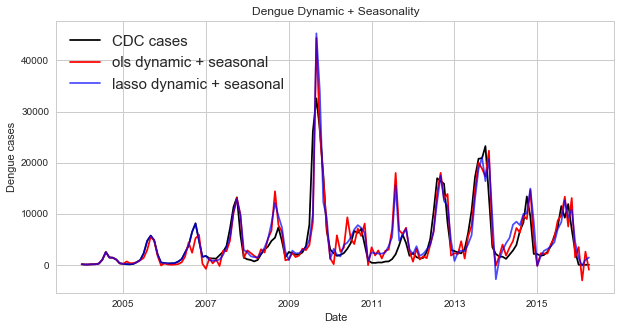

In [49]:
fig=plt.figure(figsize=(10, 5))
plt.plot(GB['dates_rec'], GB['N_cases'], 'k', label='CDC cases')
plt.plot(GB['dates_rec'], GB['Predicted_12U24'], 'r', label='ols dynamic + seasonal ')
plt.plot(GB['dates_rec'], GB['Predicted_12U24_3yrlasso'], 'b', alpha=0.7, label='lasso dynamic + seasonal')
plt.xlabel('Date')
plt.ylabel('Dengue cases')
plt.title('Dengue Dynamic + Seasonality')
pl.legend(loc='upper left', prop={'size':15})
plt.show()

In [50]:
GB['Errorlasso']=np.zeros(len(GB['dengue']))
GB['Errorols']=np.zeros(len(GB['dengue']))
for i in range(len(GB['dengue'])):
    if i<=36:
        GB.set_value(i, 'Errorlasso', 0) 
        GB.set_value(i, 'Errorols', 0)
    if i>36:
        GB.set_value(i, 'Errorlasso', GB['N_cases'][i]-GB['Predicted_12U24_3yrlasso'][i]) 
        GB.set_value(i, 'Errorols', GB['N_cases'][i]-GB['Predicted_12U24'][i]) 

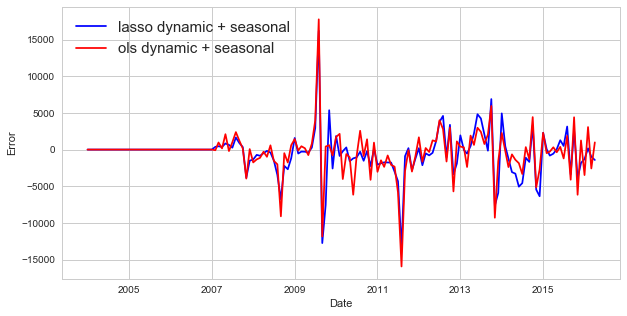

In [51]:
fig=plt.figure(figsize=(10, 5))
plt.plot(GB['dates_rec'], GB['Errorlasso'], 'b', label='lasso dynamic + seasonal')
plt.plot(GB['dates_rec'], GB['Errorols'], 'r', label='ols dynamic + seasonal')
plt.xlabel('Date')
plt.ylabel('Error')
pl.legend(loc='upper left', prop={'size':15})
plt.show()

## Feature selection

In [92]:
stepwise=feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=4)
results = stepwise.fit(GB.ix[0:36, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'dengue.hemorragico', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito', 'Case_2yr']], GB.ix[0:36, 'N_cases'])

In [45]:
print (results.scores_)
print (results.pvalues_)

[  3.96975319e+01   4.80686589e+01   3.30940240e+00   2.29161745e+01
   4.14807358e+00   1.22504276e-02   2.05893241e+00   1.92389817e-01
   5.44499213e-02   3.59976995e-01   3.38748966e+01]
[  3.10873516e-07   4.66067939e-08   7.74484558e-02   3.04706044e-05
   4.93021135e-02   9.12501055e-01   1.60192316e-01   6.63630698e-01
   8.16852850e-01   5.52384029e-01   1.33230286e-06]


In [55]:
GB['Predicted/dengue.hemorragico']=np.zeros(len(GB['dengue']))
dynamicreg=linear_model.LinearRegression()
for i in range(len(GB['dengue'])):
    if i<=1:
        GB.set_value(i, 'Predicted/dengue.hemorragico', GB['N_cases'][i])       
    if i>1:        
        dynamicreg.fit(np.asarray(GB.ix[0:i-1, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito']]), np.asarray(list(GB.ix[0:i-1, 'N_cases'].as_matrix())))
        x=np.asarray(list(GB.ix[i, ['dengue', 'dengue.dengue.dengue', 'el.dengue', 'dengue.sintomas', 'sintomas.dl.dengue', 'sintomas.de.dengue', 'que.es.dengue', 'dengue.clasico', 'dengue.mosquito']].as_matrix()))
        prd=dynamicreg.predict(x.reshape([1, 9]))
        GB.set_value(i, 'Predicted/dengue.hemorragico', prd)

## Comparisons 

In [54]:
RMSE_lassodynamic=mean_squared_error(GB['N_cases'][37:], GB['Predicted_12U24_3yrlasso'][37:])**0.5
print('RMSE lasso dynamic multi+seasonal:',  RMSE_lassodynamic)
RMSE_olsdynamic=mean_squared_error(GB['N_cases'][37:], GB['Predicted_12U24'][37:])**0.5
print('RMSE ols dynamic multi+seasonal:', RMSE_olsdynamic)
RMSE_predicted=mean_squared_error(np.array(GB['N_cases'][37:]), GB['Predicted'][37:])**0.5
print('RMSE ols dynamic multi:', RMSE_predicted)
RMSE_lassostatic=mean_squared_error(GB['N_cases'][37:], GB['Predicted_12U24_3yrlassostatic'][37:])**0.5
print('RMSE lasso static multi+seasonal:',  RMSE_lassostatic)
RMSE_olsstatic=mean_squared_error(GB['N_cases'][37:], GB['static_seasonal_ols'][37:])**0.5
print('RMSE ols static multi+seasonal:',  RMSE_olsstatic)

RMSE lasso dynamic multi+seasonal: 3532.02565606
RMSE ols dynamic multi+seasonal: 3626.75850332
RMSE ols dynamic multi: 3988.94674948
RMSE lasso static multi+seasonal: 5280.09116473
RMSE ols static multi+seasonal: 7335.30850632


In [87]:
#For the compairon plots the dengue predictions attained in the first part of the exercise with data only till 2011 were extende dto the full data set.
#1 variable ols dynamic:
GB['1_var_dynamic_ext']=np.zeros(len(GB['dengue']))
dynamicreg=linear_model.LinearRegression()
for i in range(len(GB['dengue'])):
    if i<=1:
        GB.set_value(i, '1_var_dynamic_ext', GB['N_cases'][i])       
    if i>1:        
        dynamicreg.fit(np.asarray(GB.ix[0:i-1, ['dengue']]), np.asarray(list(GB.ix[0:i-1, 'N_cases'].as_matrix())))
        x=np.asarray(list(GB.ix[i, ['dengue']].as_matrix()))
        prd=dynamicreg.predict(x.reshape([1, 1]))
        GB.set_value(i, '1_var_dynamic_ext', prd)

In [88]:
#For the compairon plots the dengue predictions attained in the first part of the exercise with data only till 2011 were extende dto the full data set.
#1 variable ols static:
GB['1_var_static_ext']=np.zeros(len(GB['dengue']))
dynamicreg=linear_model.LinearRegression()
for i in range(len(GB['dengue'])):
    if i<=36:
        GB.set_value(i, '1_var_static_ext', GB['N_cases'][i])       
    if i>36:        
        dynamicreg.fit(np.asarray(GB.ix[0:36, ['dengue']]), np.asarray(list(GB.ix[0:36, 'N_cases'].as_matrix())))
        x=np.asarray(list(GB.ix[i, ['dengue']].as_matrix()))
        prd=dynamicreg.predict(x.reshape([1, 1]))
        GB.set_value(i, '1_var_static_ext', prd)

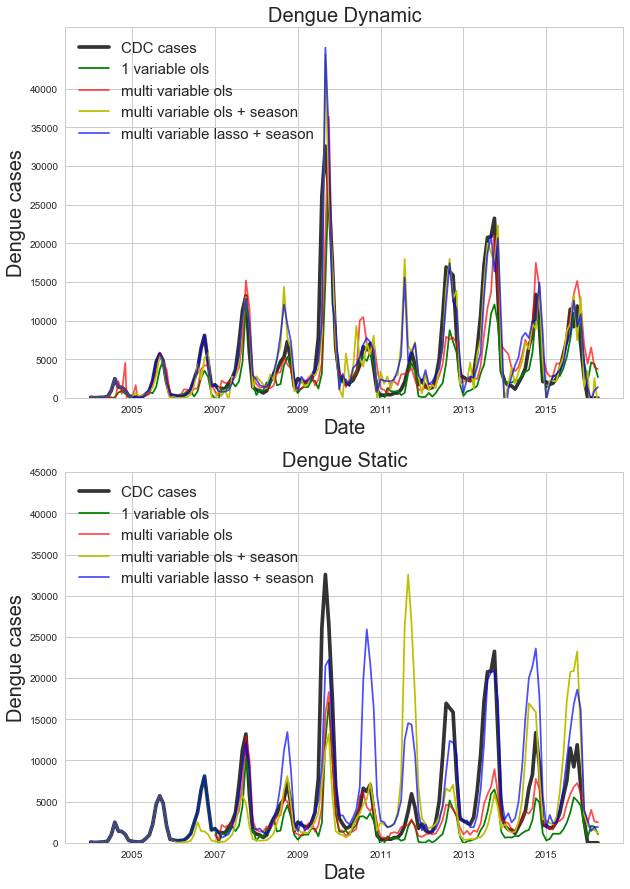

In [84]:
fig=plt.figure(figsize=(10, 15))
plt.subplot(211)
plt.plot(GB['dates_rec'], GB['N_cases'], 'k', label='CDC cases', linewidth=3.7, alpha=0.8)
plt.plot(GB['dates_rec'], GB['1_var_dynamic_ext'], 'g', label='1 variable ols')
plt.plot(GB['dates_rec'], GB['Predicted'], 'r', label='multi variable ols', alpha=0.7)
plt.plot(GB['dates_rec'], GB['Predicted_12U24'], 'y', label='multi variable ols + season', alpha=1)
plt.plot(GB['dates_rec'], GB['Predicted_12U24_3yrlasso'], 'b', label='multi variable lasso + season', alpha=0.7)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dengue cases', fontsize=20)
plt.title('Dengue Dynamic', fontsize=20)
pl.legend(loc='upper left', prop={'size':15})
plt.yticks(np.arange(0, 45000, 5000))
plt.gca().set_ylim(bottom=0)
plt.subplot(212)
plt.plot(GB['dates_rec'], GB['N_cases'], 'k',  label='CDC cases', linewidth=3.7, alpha=0.8)
plt.plot(GB['dates_rec'], GB['1_var_static_ext'], 'g', label='1 variable ols')
plt.plot(GB['dates_rec'][36:], ps_multi, 'r', label='multi variable ols', alpha=0.7)
plt.plot(GB['dates_rec'], GB['static_seasonal_ols'], 'y', label='multi variable ols + season')
plt.plot(GB['dates_rec'], GB['Predicted_12U24_3yrlassostatic'], 'b', label='multi variable lasso + season', alpha=0.7)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dengue cases', fontsize=20)
plt.title('Dengue Static', fontsize=20)
pl.legend(loc='upper left', prop={'size':15})
plt.gca().set_ylim(bottom=0, top=45000)
plt.show()

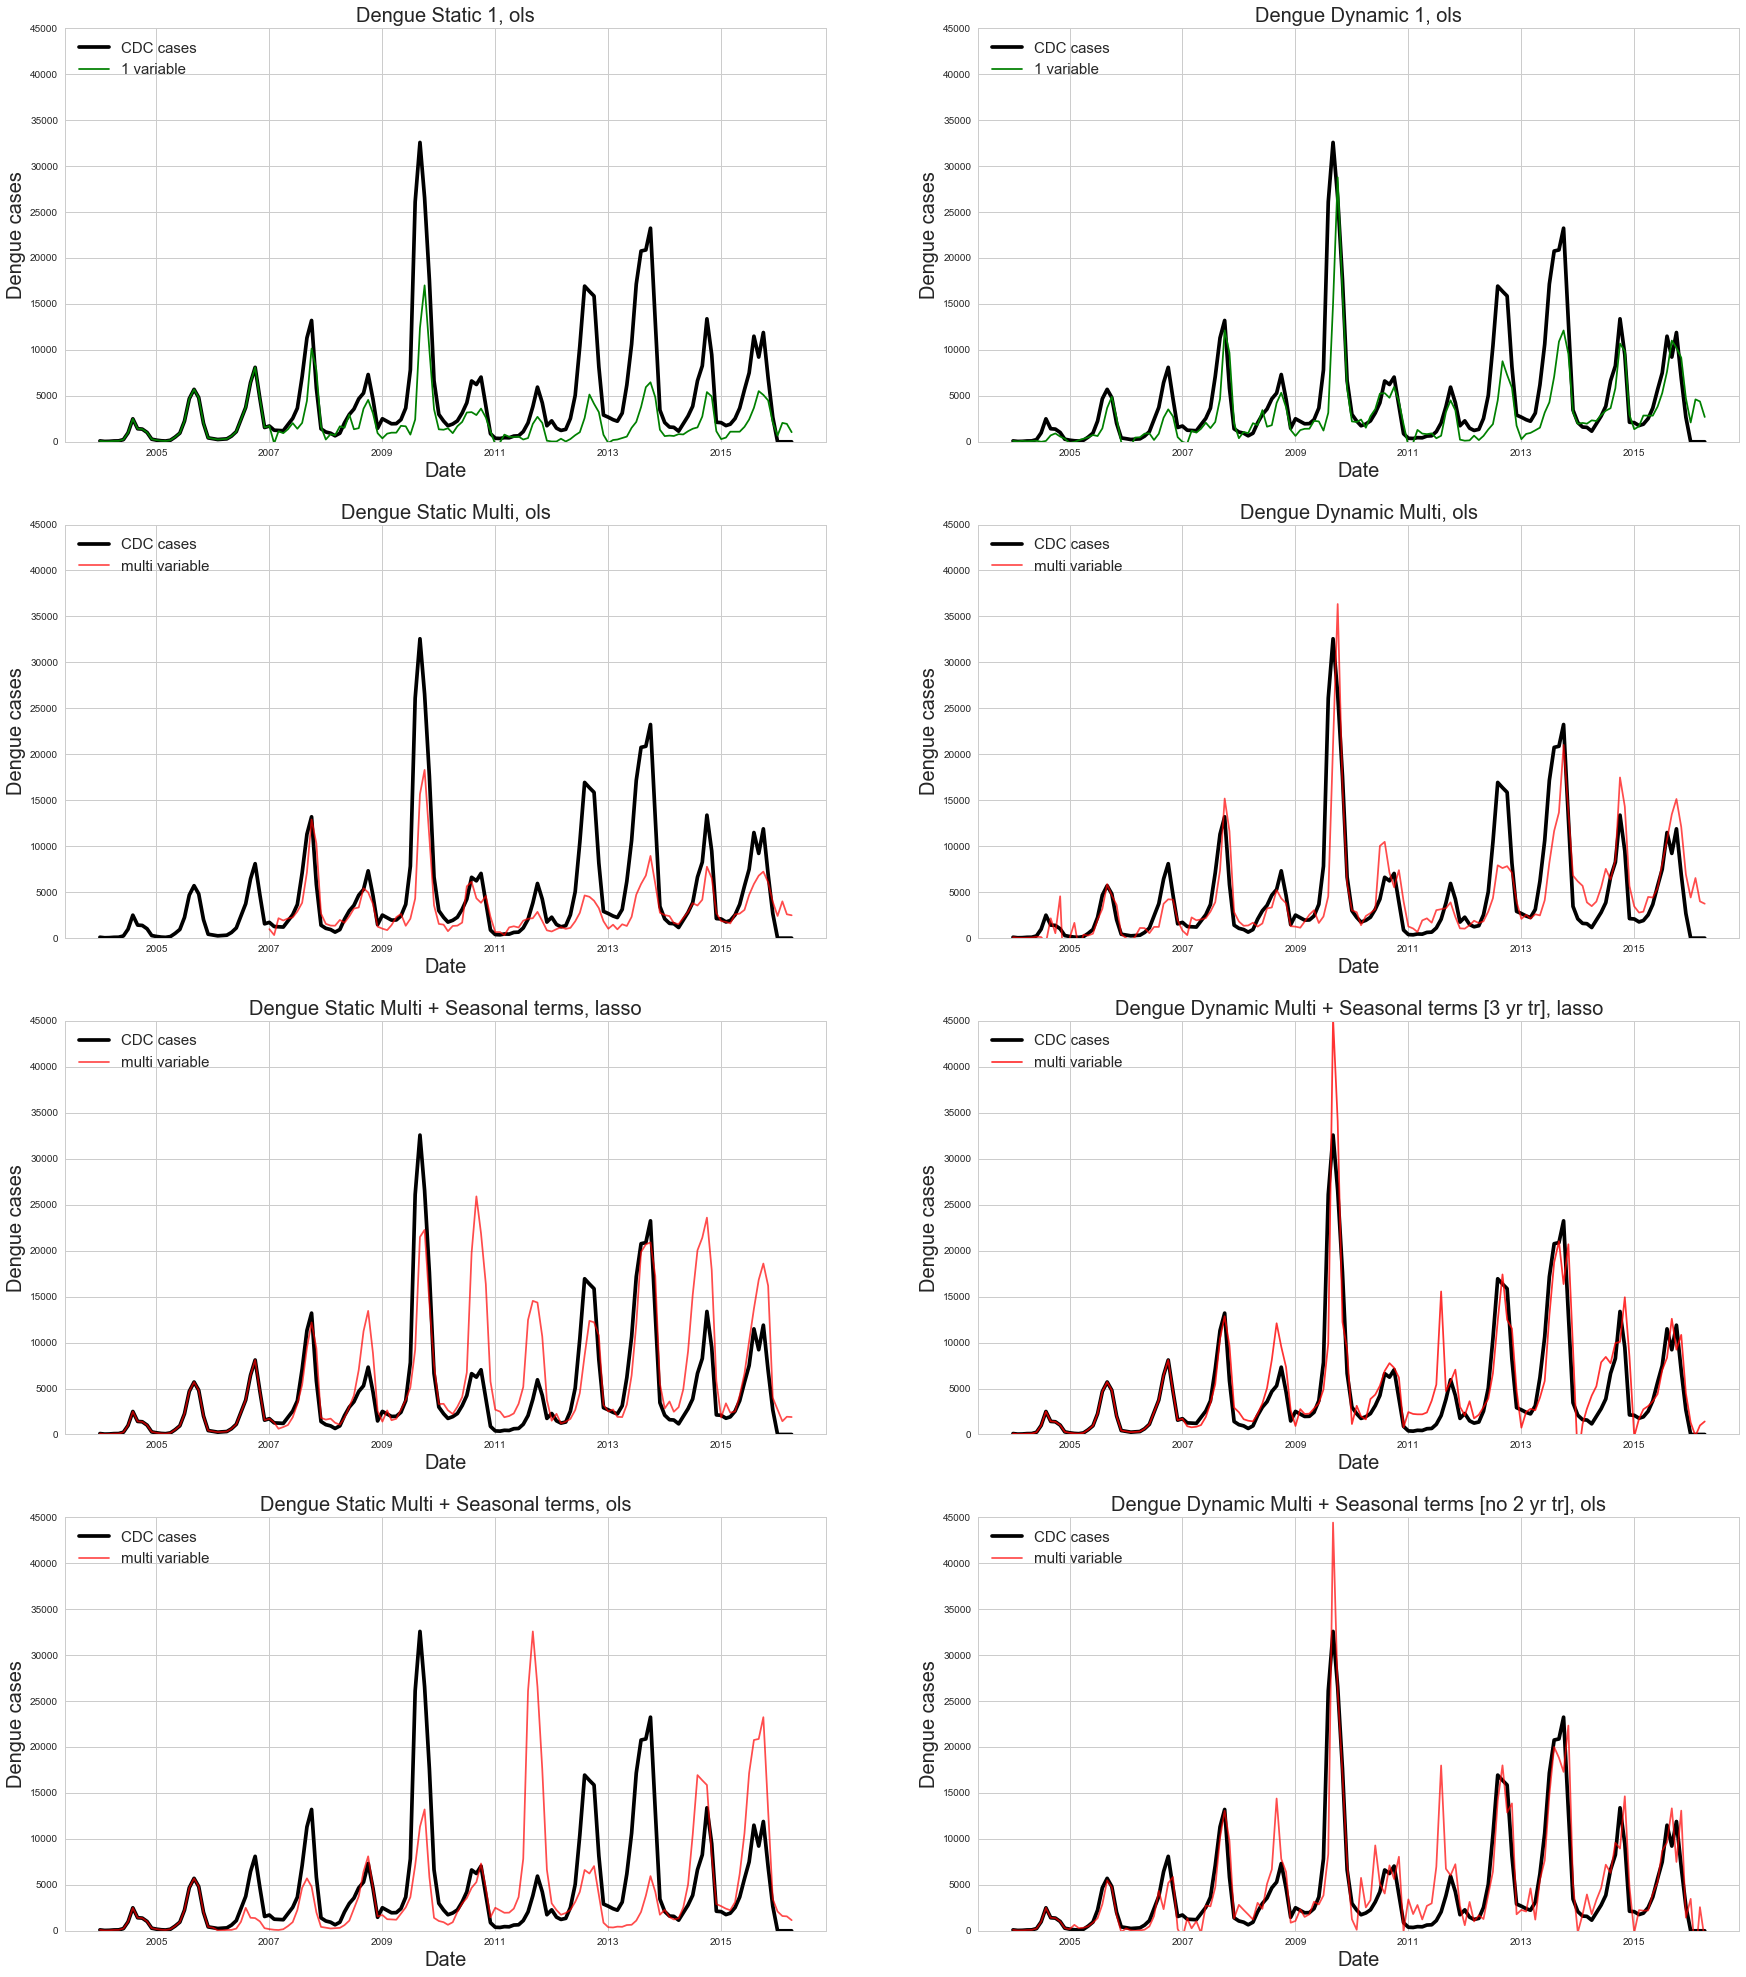

In [85]:
fig=plt.figure(figsize=(30, 35))
plt.subplot(421)
plt.plot(GB['dates_rec'], GB['N_cases'], 'k',  label='CDC cases', linewidth=3.7)
plt.plot(GB['dates_rec'], GB['1_var_static_ext'], 'g', label='1 variable')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dengue cases', fontsize=20)
plt.title('Dengue Static 1, ols', fontsize=20)
pl.legend(loc='upper left', prop={'size':15})
plt.gca().set_ylim(bottom=0, top=45000)
plt.subplot(423)
plt.plot(GB['dates_rec'], GB['N_cases'], 'k',  label='CDC cases', linewidth=3.7)
plt.plot(GB['dates_rec'][36:], ps_multi, 'r', label='multi variable', alpha=0.7)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dengue cases', fontsize=20)
plt.title('Dengue Static Multi, ols', fontsize=20)
pl.legend(loc='upper left', prop={'size':15})
plt.gca().set_ylim(bottom=0, top=45000)
plt.subplot(425)
plt.plot(GB['dates_rec'], GB['N_cases'], 'k',  label='CDC cases', linewidth=3.7)
plt.plot(GB['dates_rec'], GB['Predicted_12U24_3yrlassostatic'], 'r', label='multi variable', alpha=0.7)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dengue cases', fontsize=20)
plt.title('Dengue Static Multi + Seasonal terms, lasso', fontsize=20)
pl.legend(loc='upper left', prop={'size':15})
plt.gca().set_ylim(bottom=0, top=45000)
plt.subplot(422)
plt.plot(GB['dates_rec'], GB['N_cases'], 'k', label='CDC cases', linewidth=3.7)
plt.plot(GB['dates_rec'], GB['1_var_dynamic_ext'], 'g', label='1 variable')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dengue cases', fontsize=20)
plt.title('Dengue Dynamic 1, ols', fontsize=20)
pl.legend(loc='upper left', prop={'size':15})
plt.gca().set_ylim(bottom=0, top=45000)
plt.subplot(424)
plt.plot(GB['dates_rec'], GB['N_cases'], 'k', label='CDC cases', linewidth=3.7)
plt.plot(GB['dates_rec'], GB['Predicted'], 'r', label='multi variable', alpha=0.7)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dengue cases', fontsize=20)
plt.title('Dengue Dynamic Multi, ols', fontsize=20)
pl.legend(loc='upper left', prop={'size':15})
plt.gca().set_ylim(bottom=0, top=45000)
plt.subplot(428)
plt.plot(GB['dates_rec'], GB['N_cases'], 'k', label='CDC cases', linewidth=3.7)
plt.plot(GB['dates_rec'], GB['Predicted_12U24'], 'r', label='multi variable', alpha=0.7)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dengue cases', fontsize=20)
plt.title('Dengue Dynamic Multi + Seasonal terms [no 2 yr tr], ols', fontsize=20)
pl.legend(loc='upper left', prop={'size':15})
plt.gca().set_ylim(bottom=0, top=45000)
plt.subplot(427)
plt.plot(GB['dates_rec'], GB['N_cases'], 'k', label='CDC cases', linewidth=3.7)
plt.plot(GB['dates_rec'], GB['static_seasonal_ols'], 'r', label='multi variable', alpha=0.7)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dengue cases', fontsize=20)
plt.title('Dengue Static Multi + Seasonal terms, ols', fontsize=20)
pl.legend(loc='upper left', prop={'size':15})
plt.gca().set_ylim(bottom=0, top=45000)
plt.subplot(426)
plt.plot(GB['dates_rec'], GB['N_cases'], 'k', label='CDC cases', linewidth=3.7)
plt.plot(GB['dates_rec'], GB['Predicted_12U24_3yrlasso'], 'r', label='multi variable', alpha=0.8)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dengue cases', fontsize=20)
plt.title('Dengue Dynamic Multi + Seasonal terms [3 yr tr], lasso', fontsize=20)
pl.legend(loc='upper left', prop={'size':15})
plt.gca().set_ylim(bottom=0, top=45000)
plt.show()